In [154]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import random

In [155]:
# Set random seed for full reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load and preapre data

In [156]:
# Load data
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain'].flatten().reshape(-1, 1) #check this

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create window sequences
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps].flatten())
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

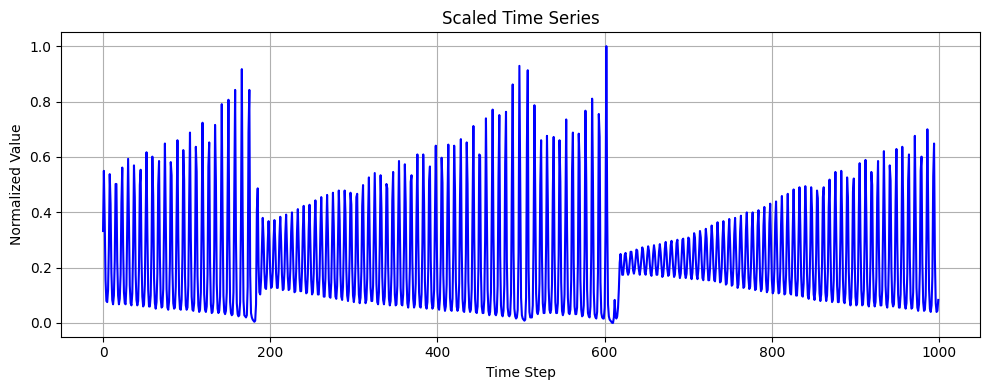

In [157]:
# Plot the scaled data
plt.figure(figsize=(10, 4))
plt.plot(scaled, color='blue')
plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Model

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], 1)
        )

    def forward(self, x):
        return self.net(x)

### Hyperparameter GridSearch

In [ ]:
n_steps_list = [20, 40, 50, 60, 80, 100]
lrs = [0.0005, 0.001, 0.005]
#hidden_size_sets = [(64, 32)]
hidden_size_sets = [(32, 16), (64, 32), (128, 64)]

#Explain all of them...
best_val_loss = float('inf')
best_config = None
best_model_state = None
best_train_losses = []
best_val_losses = []
all_results = []


for n_steps, lr, hidden_sizes in product(n_steps_list, lrs, hidden_size_sets):
    print(f"\nTraining with n_steps={n_steps}, lr={lr}, hidden_sizes={hidden_sizes}")

    # Prepare data
    X, y = create_dataset(scaled, n_steps)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Init model
    model = FeedForwardNN(n_steps, hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping config
    patience = 5
    min_delta = 1e-4
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    max_epochs = 100
    train_losses = []
    val_losses = []

    # Train
    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        #Early stopping check
        if val_loss.item() < best_loss - min_delta:
            best_loss = val_loss.item()
            epochs_no_improve = 0
            best_local_state = model.state_dict()
            best_train_local = train_losses.copy()
            best_val_local = val_losses.copy()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Store result of this config
    all_results.append({
        'n_steps': n_steps,
        'lr': lr,
        'hidden_sizes': hidden_sizes,
        'val_loss': best_loss
    })


    # Save best losses
    if best_loss < best_val_loss:
        best_val_loss = best_loss
        best_config = (n_steps, lr, hidden_sizes)
        best_model_state = best_local_state
        best_train_losses = best_train_local
        best_val_losses = best_val_local


Training with n_steps=20, lr=0.0005, hidden_sizes=(16, 16)

Training with n_steps=20, lr=0.0005, hidden_sizes=(32, 16)

Training with n_steps=20, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.0005, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.001, hidden_sizes=(16, 16)

Training with n_steps=20, lr=0.001, hidden_sizes=(32, 16)

Training with n_steps=20, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.005, hidden_sizes=(16, 16)

Training with n_steps=20, lr=0.005, hidden_sizes=(32, 16)

Training with n_steps=20, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.0005, hidden_sizes=(16, 16)

Training with n_steps=40, lr=0.0005, hidden_sizes=(32, 16)

Training with n_steps=40, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.0005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.001, hidden_

In [160]:
# ---- Final result ----
print("\nBest Model Found:")
print(f"n_steps={best_config[0]}, lr={best_config[1]}, hidden_sizes={best_config[2]}")
print(f"Validation Loss: {best_val_loss:.6f}")

# Load best model
best_model = FeedForwardNN(best_config[0], best_config[2])
best_model.load_state_dict(best_model_state)
best_model.eval()


Best Model Found:
n_steps=100, lr=0.005, hidden_sizes=(128, 64)
Validation Loss: 0.000699


FeedForwardNN(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [161]:
df_results = pd.DataFrame(all_results)
df_results['params'] = df_results.apply(
    lambda row: f"n={row['n_steps']}, lr={row['lr']}, h={row['hidden_sizes']}", axis=1
)

# Print sorted results
print("\nAll Config Results (sorted):")
print(df_results.sort_values("val_loss"))


All Config Results (sorted):
    n_steps      lr hidden_sizes  val_loss                        params
71      100  0.0050    (128, 64)  0.000699  n=100, lr=0.005, h=(128, 64)
59       80  0.0050    (128, 64)  0.000704   n=80, lr=0.005, h=(128, 64)
11       20  0.0050    (128, 64)  0.000830   n=20, lr=0.005, h=(128, 64)
47       60  0.0050    (128, 64)  0.000841   n=60, lr=0.005, h=(128, 64)
58       80  0.0050     (64, 32)  0.001027    n=80, lr=0.005, h=(64, 32)
..      ...     ...          ...       ...                           ...
45       60  0.0050     (32, 16)  0.033767    n=60, lr=0.005, h=(32, 16)
32       50  0.0050     (16, 16)  0.035556    n=50, lr=0.005, h=(16, 16)
51       80  0.0005    (128, 64)  0.036712  n=80, lr=0.0005, h=(128, 64)
40       60  0.0010     (16, 16)  0.037818    n=60, lr=0.001, h=(16, 16)
66      100  0.0010     (64, 32)  0.038468   n=100, lr=0.001, h=(64, 32)

[72 rows x 5 columns]


In [162]:
# Plot 1: Best Model Loss Evolution Through Epochs
def plot_best_model_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model Loss Evolution Through Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bar_plot_val_loss_vs_n_steps_best_config(all_results):
    df = pd.DataFrame(all_results)

    # Find the best overall config (lowest validation loss)
    best_row = df.loc[df['val_loss'].idxmin()]
    best_lr = best_row['lr']
    best_hidden = best_row['hidden_sizes']

    # Filter to only rows with best lr and hidden sizes
    filtered_df = df[(df['lr'] == best_lr) & (df['hidden_sizes'] == best_hidden)]
    filtered_df = filtered_df.sort_values(by='n_steps')

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(filtered_df['n_steps'].astype(str), filtered_df['val_loss'])
    plt.xlabel('n_steps')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss by n_steps (best config: lr={best_lr}, h={best_hidden})')
    plt.grid(axis='y')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


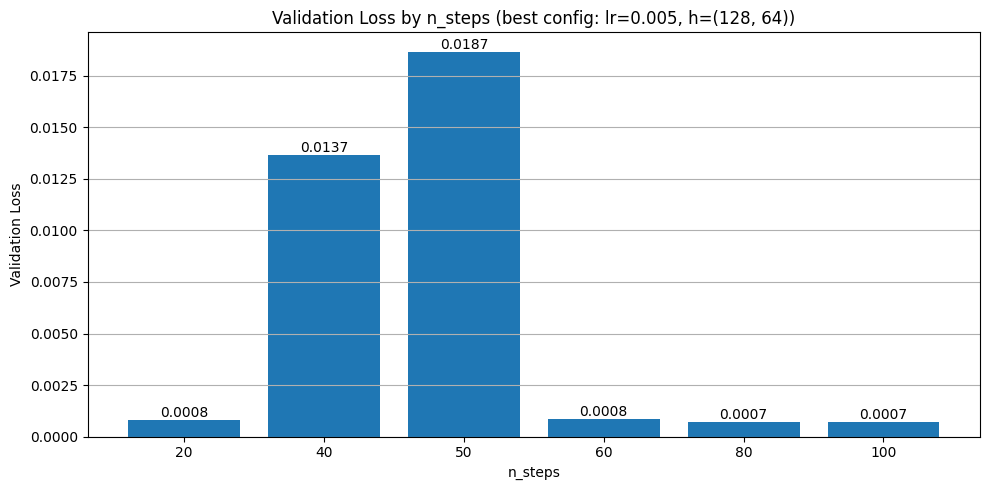

In [163]:
# Call after your search
bar_plot_val_loss_vs_n_steps_best_config(all_results)

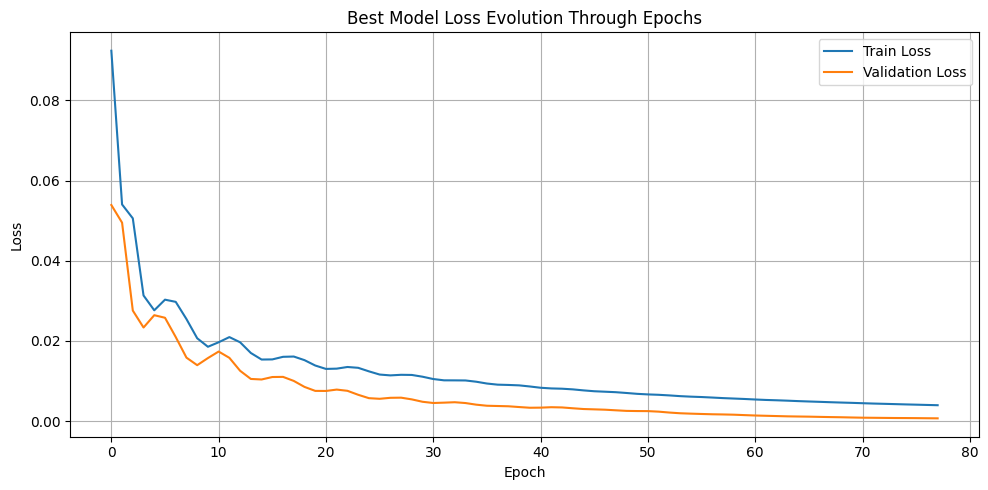

In [164]:
plot_best_model_loss(best_train_losses, best_val_losses)

In [165]:
'''

# ---- Plotting ----

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
'''


'''
# ----  Recursive Forecasting in PyTorch ----

def recursive_forecast(model, seed_seq, n_future, scaler):
    model.eval()
    forecast = []
    input_seq = seed_seq.copy()

    for _ in range(n_future):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        with torch.no_grad():
            next_val = model(input_tensor).item()
        forecast.append(next_val)
        input_seq = input_seq[1:] + [next_val]  # Slide the window

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

# Use the last real window as seed
last_window = scaled[-n_steps:].flatten().tolist()
future_preds = recursive_forecast(model, last_window, n_future=50, scaler=scaler)

# Inverse transform the full scaled dataset back to original scale for plotting
real_data = scaler.inverse_transform(scaled)

# Create an array combining the original data with predictions
extended = np.concatenate((real_data.flatten(), future_preds))

# Create time axis
time_axis = np.arange(len(extended))
real_axis = np.arange(len(real_data))
pred_axis = np.arange(len(real_data), len(extended))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time_axis, extended, label='Extended (Real + Predicted)', linestyle='--', color='gray')
plt.plot(real_axis, real_data, label='Real Data', color='blue')
plt.plot(pred_axis, future_preds, label='Predictions', color='red')
plt.title('Real Data and 50-Step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

'''

"\n# ----  Recursive Forecasting in PyTorch ----\n\ndef recursive_forecast(model, seed_seq, n_future, scaler):\n    model.eval()\n    forecast = []\n    input_seq = seed_seq.copy()\n\n    for _ in range(n_future):\n        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)\n        with torch.no_grad():\n            next_val = model(input_tensor).item()\n        forecast.append(next_val)\n        input_seq = input_seq[1:] + [next_val]  # Slide the window\n\n    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))\n    return forecast.flatten()\n\n# Use the last real window as seed\nlast_window = scaled[-n_steps:].flatten().tolist()\nfuture_preds = recursive_forecast(model, last_window, n_future=50, scaler=scaler)\n\n# Inverse transform the full scaled dataset back to original scale for plotting\nreal_data = scaler.inverse_transform(scaled)\n\n# Create an array combining the original data with predictions\nextended = np.concatenate((real_data.flatt